# Invoice Field Detection — U-Net / Deep Learning

Este notebook implementa un pipeline completo de detección de campos en facturas/recibos.  
El dataset contiene:
- **`data/img/`** — imágenes de recibos (626 JPGs)
- **`data/box/`** — anotaciones de bounding boxes (CSV: `x1,y1,x2,y2,x3,y3,x4,y4,texto`)
- **`data/key/`** — etiquetas de campos clave (JSON: `company`, `date`, `address`, `total`)

**Objetivo:** Localizar y clasificar los campos clave (`company`, `date`, `address`, `total`) dentro de cada imagen de recibo mediante segmentación semántica con U-Net.

## 1. Importar Librerías

Este código realiza dos funciones principales para preparar el entorno:

Importación de Librerías: Carga todas las herramientas necesarias:

- TensorFlow/Keras: Para crear y entrenar la red neuronal (U-Net).
OpenCV (cv2): Para leer y procesar las imágenes.
Pandas y NumPy: Para manipular los datos (CSV de cajas y arrays).

- Matplotlib: Para visualizar las facturas y los resultados.
Descarga Automática del Dataset: Verifica si la carpeta data/img existe. Si no está (por ejemplo, al iniciar una nueva sesión en Colab), clona automáticamente el repositorio de GitHub ICDAR-2019-SROIE, mueve los datos a la carpeta local ./data y borra los archivos temporales. Esto asegura que siempre tengas los datos listos sin tener que subirlos manualmente.

In [11]:
import os
import glob
import shutil
import json
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

print(f"TensorFlow version: {tf.__version__}")
print(f"GPU disponible: {tf.config.list_physical_devices('GPU')}")

# ─── Descarga y Configuración del Dataset (Github) ────────────────────────────
# Verificamos si existe la carpeta de imágenes
if not os.path.exists("data/img"):
    print("⚠️ Dataset no encontrado en el entorno. Descargando desde GitHub...")
    # Limpiar residuos si existen
    if os.path.exists("ICDAR-2019-SROIE"):
        shutil.rmtree("ICDAR-2019-SROIE")

    # Clonar repo
    os.system("git clone https://github.com/zzzDavid/ICDAR-2019-SROIE.git")

    # Mover carpeta data
    if os.path.exists("ICDAR-2019-SROIE/data"):
        if os.path.exists("data"):
            shutil.rmtree("data")
        shutil.move("ICDAR-2019-SROIE/data", ".")
        print("✅ Datos descargados y organizados en './data'.")

    # Limpieza final
    if os.path.exists("ICDAR-2019-SROIE"):
        shutil.rmtree("ICDAR-2019-SROIE")
else:
    print("✅ Dataset ya presente en './data'.")

TensorFlow version: 2.20.0
GPU disponible: []
✅ Dataset ya presente en './data'.


Este código analiza la calidad y balance del dataset:

**Recuperación de Datos:** Si por alguna razón la lista de imágenes (all_indices) se perdió, intenta regenerarla escaneando la carpeta.

**Conteo de Campos:** Recorre cada archivo JSON (etiquetas) y verifica qué campos clave (company, date, address, total) tienen valor y cuáles están vacíos.

**Visualización: Genera dos gráficos de barras:**
Izquierda: Cantidad de facturas que tienen cada campo.
Derecha: Cantidad de facturas a las que les falta ese campo (útil para saber qué tan difícil será para el modelo aprender ciertos datos).

In [12]:
# ─── Rutas del dataset ───────────────────────────────────────────────────────
BASE_DIR  = os.path.dirname(os.path.abspath("invoice_field_detection.ipynb"))
DATA_DIR  = os.path.join(BASE_DIR, "data")
IMG_DIR   = os.path.join(DATA_DIR, "img")
BOX_DIR   = os.path.join(DATA_DIR, "box")
KEY_DIR   = os.path.join(DATA_DIR, "key")

# ─── Hiperparámetros (Configuración Rápida) ───────────────────────────────────
IMG_H, IMG_W = 256, 256          # Reducido de 512 a 256 para agilizar entrenamiento CPU
NUM_CLASSES  = 5                 # background, company, date, address, total
BATCH_SIZE   = 16                # Aumentado para compensar menor resolución
EPOCHS       = 15                # Reducido para pruebas rápidas
SEED         = 42

# Mapa de campo → clase
FIELD_CLASSES = {"background": 0, "company": 1, "date": 2, "address": 3, "total": 4}
CLASS_COLORS  = {0: (0,0,0), 1: (255,0,0), 2: (0,255,0), 3: (0,0,255), 4: (255,255,0)}
CLASS_NAMES   = ["background", "company", "date", "address", "total"]

print("Rutas y Hiperparámetros actualizados.")
print(f"  IMG_DIR : {IMG_DIR}")
print(f"  Config  : {IMG_H}x{IMG_W} px, {EPOCHS} épocas, Batch {BATCH_SIZE}")
print("⚠️ Nota: Si cambias esto, debes re-ejecutar 'Crear Dataset' y 'Construir Modelo'.")

Rutas y Hiperparámetros actualizados.
  IMG_DIR : c:\Users\Gerardo\OneDrive - Oracle Corporation\Documents\ProyectoFinal\invoicesUNETAnalisis\data\img
  Config  : 256x256 px, 15 épocas, Batch 16
⚠️ Nota: Si cambias esto, debes re-ejecutar 'Crear Dataset' y 'Construir Modelo'.


## 2. Cargar y Explorar el Dataset

Este código define la función esencial para cargar los datos y verifica que el dataset sea accesible:

**load_sample(idx):** Es la función principal.
- Lee la imagen (.jpg).
- Lee las cajas de texto (.csv): Implementa una lectura manual línea por línea para evitar errores con comas dentro del texto (un problema común en este dataset).
- Carga las etiquetas (.json): Diccionario con los valores reales de company, date, address, total.
Indexación: Crea la lista all_indices escaneando todos los archivos .jpg en la carpeta.
Prueba: Carga el primer recibo (000) y muestra sus dimensiones y datos para confirmar que todo funciona bien.

In [13]:
def load_sample(idx: str):
    """
    Carga imagen, bounding boxes y etiquetas clave para un índice dado.
    El CSV tiene columnas: x1,y1,x2,y2,x3,y3,x4,y4,text  (sin encabezado)
    El JSON contiene: company, date, address, total
    """
    img_path = os.path.join(IMG_DIR, f"{idx}.jpg")
    box_path = os.path.join(BOX_DIR, f"{idx}.csv")
    key_path = os.path.join(KEY_DIR, f"{idx}.json")

    img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)

    # Manual parsing to handle commas in the text field
    data = []
    with open(box_path, "r", encoding="utf-8", errors="ignore") as f:
        for line in f:
            parts = line.strip().split(",")
            # We expect at least 8 coordinates + 1 text (or empty text)
            if len(parts) >= 8:
                try:
                    # Extract coordinates (first 8 values)
                    coords = [int(p) for p in parts[:8]]
                    # The rest is the text (re-joined in case of commas)
                    text = ",".join(parts[8:])
                    data.append(coords + [text])
                except ValueError:
                    # Skip malformed lines (e.g. headers or non-integer coords)
                    continue

    boxes_df = pd.DataFrame(data, columns=["x1","y1","x2","y2","x3","y3","x4","y4","text"])

    with open(key_path) as f:
        keys = json.load(f)

    return img, boxes_df, keys


# ─── Listar todos los índices disponibles ────────────────────────────────────
all_indices = sorted([
    os.path.splitext(os.path.basename(p))[0]
    for p in glob.glob(os.path.join(IMG_DIR, "*.jpg"))
])

print(f"Total de muestras: {len(all_indices)}")
print(f"Primeros índices  : {all_indices[:5]}")
print(f"Últimos índices   : {all_indices[-5:]}")

# ─── Estadísticas básicas ─────────────────────────────────────────────────────
if all_indices:
    img_sample, boxes_sample, keys_sample = load_sample(all_indices[0])
    print(f"\nEjemplo índice {all_indices[0]}:")
    print(f"  Imagen shape : {img_sample.shape}")
    print(f"  Num bboxes   : {len(boxes_sample)}")
    print(f"  Campos clave : {list(keys_sample.keys())}")
    print(f"  Valores      : {keys_sample}")
else:
    print("No se encontraron imágenes en el directorio data/img.")

Total de muestras: 626
Primeros índices  : ['000', '001', '002', '003', '004']
Últimos índices   : ['621', '622', '623', '624', '625']

Ejemplo índice 000:
  Imagen shape : (1013, 463, 3)
  Num bboxes   : 44
  Campos clave : ['company', 'date', 'address', 'total']
  Valores      : {'company': 'BOOK TA .K (TAMAN DAYA) SDN BHD', 'date': '25/12/2018', 'address': 'NO.53 55,57 & 59, JALAN SAGU 18, TAMAN DAYA, 81100 JOHOR BAHRU, JOHOR.', 'total': '9.00'}


Este código permite visualizar cómo se relacionan las cajas de texto con los campos clave:

- **find_key_boxes:** Es el "cerebro" de la etiqueta. Busca dentro de todas las cajas de texto del recibo aquellas palabras que coinciden con los valores reales (company, date, etc.) del archivo JSON.
- **draw_annotated:** Pinta sobre la imagen. Dibuja en gris el texto irrelevante y colorea las cajas detectadas como campos clave (Rojo=Empresa, Verde=Fecha, etc.).
Muestreo Aleatorio: Selecciona 6 recibos al azar y muestra el resultado final para que puedas verificar visualmente si las etiquetas son correctas.

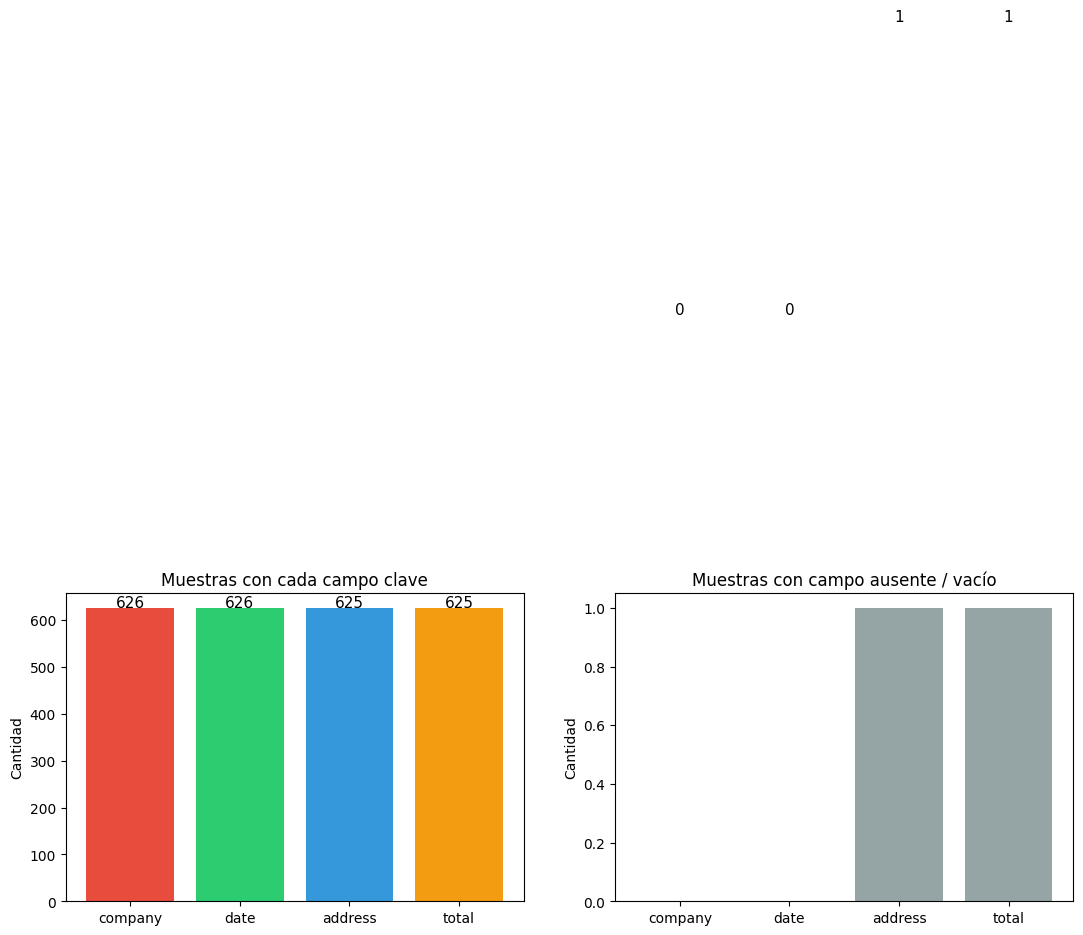

In [14]:
# ─── Distribución de campos clave en todo el dataset ─────────────────────────

# Recuperar all_indices si no está definido (por seguridad, si se saltaron celdas)
if 'all_indices' not in locals() or not all_indices:
    _img_dir_check = "data/img"
    if os.path.exists(_img_dir_check):
        all_indices = sorted([
            os.path.splitext(os.path.basename(p))[0]
            for p in glob.glob(os.path.join(_img_dir_check, "*.jpg"))
        ])
    else:
        all_indices = []

# Asegurar variables de ruta para esta celda
if 'KEY_DIR' not in locals():
    KEY_DIR = os.path.abspath("data/key")

if 'FIELD_CLASSES' not in locals():
    FIELD_CLASSES = {"background": 0, "company": 1, "date": 2, "address": 3, "total": 4}

if all_indices:
    field_counts = {f: 0 for f in FIELD_CLASSES if f != "background"}
    missing       = {f: 0 for f in field_counts}

    for idx in all_indices:
        key_path = os.path.join(KEY_DIR, f"{idx}.json")
        try:
            with open(key_path) as f:
                keys = json.load(f)
            for field in field_counts:
                if keys.get(field):
                    field_counts[field] += 1
                else:
                    missing[field] += 1
        except Exception:
            pass

    fig, axes = plt.subplots(1, 2, figsize=(13, 4))

    axes[0].bar(field_counts.keys(), field_counts.values(), color=["#E74C3C","#2ECC71","#3498DB","#F39C12"])
    axes[0].set_title("Muestras con cada campo clave")
    axes[0].set_ylabel("Cantidad")
    for i, (k, v) in enumerate(field_counts.items()):
        axes[0].text(i, v + 2, str(v), ha="center", fontsize=11)

    axes[1].bar(missing.keys(), missing.values(), color="#95A5A6")
    axes[1].set_title("Muestras con campo ausente / vacío")
    axes[1].set_ylabel("Cantidad")
    for i, (k, v) in enumerate(missing.items()):
        axes[1].text(i, v + 2, str(v), ha="center", fontsize=11)

    plt.tight_layout()
    plt.show()
else:
    print("❌ Error: No se encontraron datos para graficar.")

## 3. Visualizar Imágenes con Bounding Boxes

Este código define la arquitectura de la red neuronal U-Net para la segmentación:

Encoder (MobileNetV2): Usamos una red preentrenada (MobileNetV2) como "columna vertebral" para extraer características. Se congela (trainable=False) para no dañar los pesos aprendidos en ImageNet al inicio.
Skip Connections: Extraemos capas intermedias del encoder (s1, s2, etc.) para capturar detalles finos a diferentes resoluciones.
Decoder: Reconstruye la imagen paso a paso (upsample_block). En cada paso, duplica el tamaño y concatena la skip connection correspondiente para recuperar la información espacial perdida.
Salida: La última capa tiene 5 filtros (uno por clase) con activación softmax, generando una probabilidad para cada píxel.

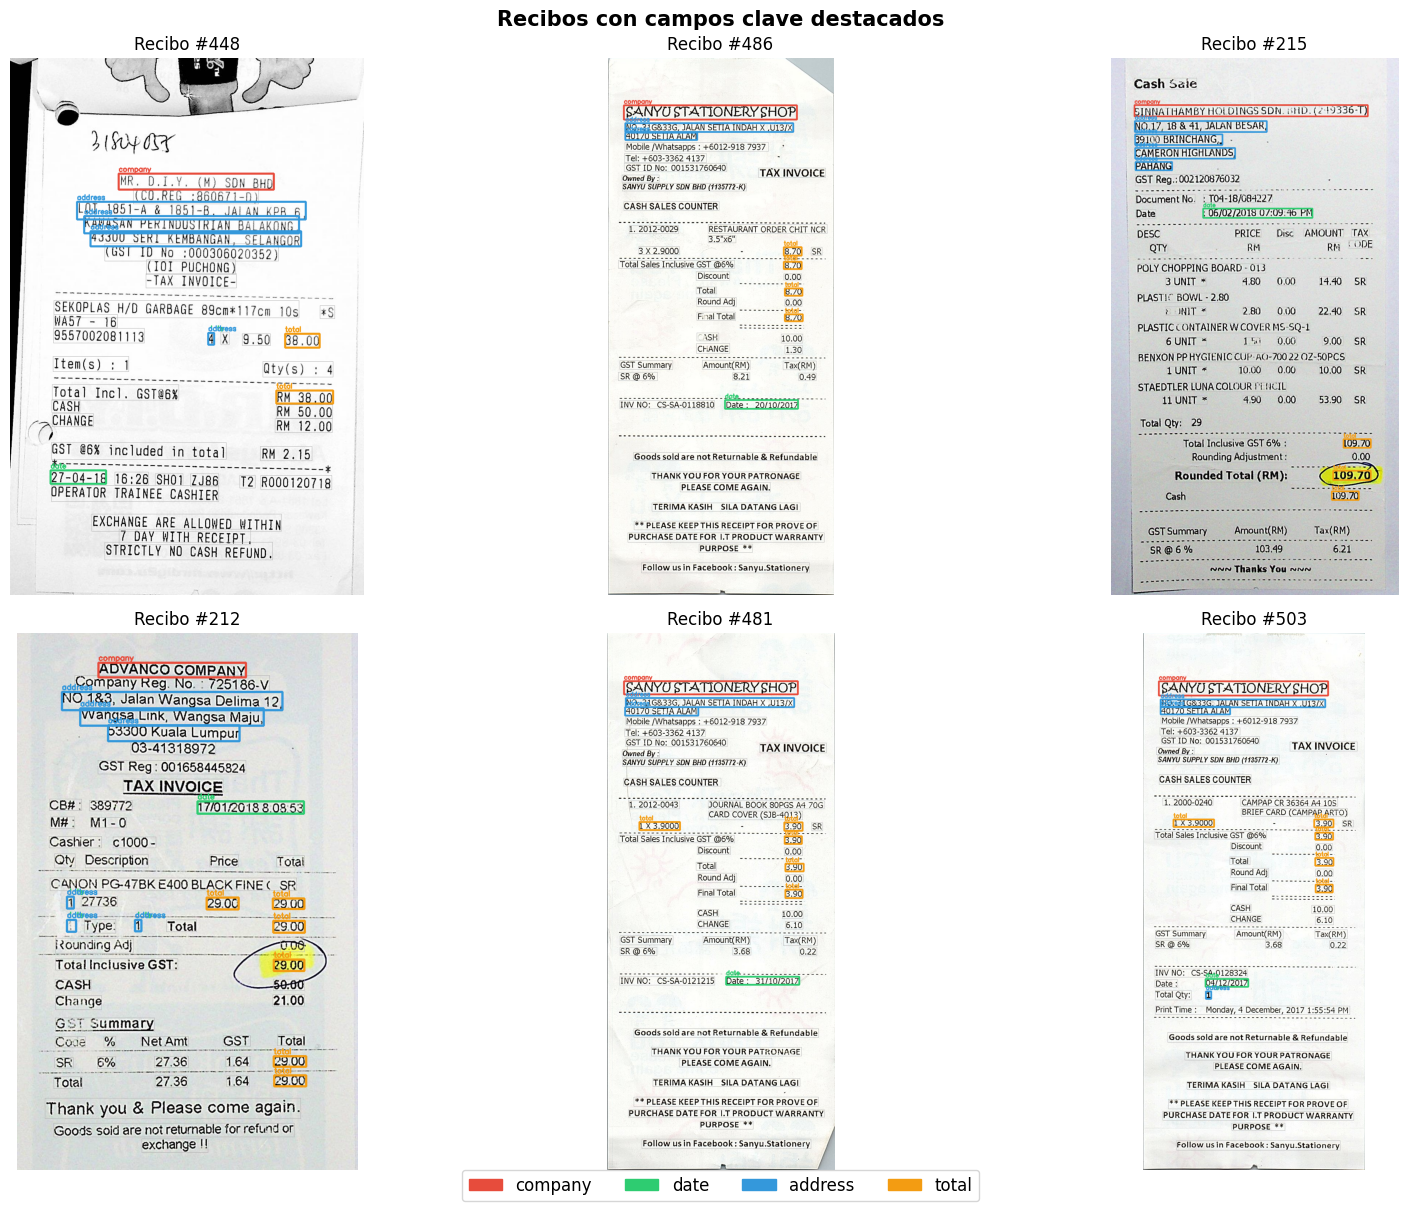

In [15]:
def find_key_boxes(boxes_df: pd.DataFrame, keys: dict) -> dict:
    """
    Busca en boxes_df las filas cuyo texto coincide (parcialmente) con el
    valor de cada campo clave. Retorna {field: list_of_row_indices}.
    """
    matched = {f: [] for f in keys}
    for field, value in keys.items():
        if not value:
            continue
        # Búsqueda fuzzy: normalizar a minúsculas, buscar substring
        value_norm = value.lower().strip()
        for i, row in boxes_df.iterrows():
            if str(row["text"]).lower().strip() in value_norm or \
               value_norm in str(row["text"]).lower().strip():
                matched[field].append(i)
    return matched


def draw_annotated(img, boxes_df, keys, title=""):
    """Dibuja todas las bboxes en gris y los campos clave en color."""
    color_map = {"company":"#E74C3C","date":"#2ECC71","address":"#3498DB","total":"#F39C12"}
    canvas = img.copy()
    matched = find_key_boxes(boxes_df, keys)

    # Pintar bboxes de texto genérico
    for _, row in boxes_df.iterrows():
        pts = np.array([[row.x1,row.y1],[row.x2,row.y2],
                        [row.x3,row.y3],[row.x4,row.y4]], np.int32)
        cv2.polylines(canvas, [pts.reshape(-1,1,2)], True, (180,180,180), 1)

    # Pintar campos clave
    for field, idxs in matched.items():
        hex_c = color_map[field].lstrip("#")
        r,g,b = tuple(int(hex_c[i:i+2],16) for i in (0,2,4))
        for i in idxs:
            row = boxes_df.loc[i]
            pts = np.array([[row.x1,row.y1],[row.x2,row.y2],
                            [row.x3,row.y3],[row.x4,row.y4]], np.int32)
            cv2.polylines(canvas,[pts.reshape(-1,1,2)],True,(r,g,b),3)
            cv2.putText(canvas, field, (int(row.x1), int(row.y1)-5),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.55, (r,g,b), 2)
    return canvas


# ─── Mostrar 6 muestras aleatorias ───────────────────────────────────────────
np.random.seed(SEED)
sample_ids = np.random.choice(all_indices, 6, replace=False)

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
for ax, idx in zip(axes.flat, sample_ids):
    img, boxes_df, keys = load_sample(idx)
    canvas = draw_annotated(img, boxes_df, keys, title=idx)
    ax.imshow(canvas)
    ax.set_title(f"Recibo #{idx}", fontsize=12)
    ax.axis("off")

# Leyenda
from matplotlib.patches import Patch
legend_handles = [Patch(color=c, label=l) for l, c in
                  [("company","#E74C3C"),("date","#2ECC71"),
                   ("address","#3498DB"),("total","#F39C12")]]
fig.legend(handles=legend_handles, loc="lower center", ncol=4, fontsize=12,
           bbox_to_anchor=(0.5, -0.02))
plt.suptitle("Recibos con campos clave destacados", fontsize=15, fontweight="bold")
plt.tight_layout()
plt.show()

## 4. Preprocesar Imágenes y Generar Máscaras de Segmentación

Este código es crucial: convierte los datos crudos en lo que la red neuronal necesita ver (Imágenes + Máscaras).

- **build_segmentation_mask:** Crea una "imagen fantasma" (máscara) del mismo tamaño que la factura. Pinta los píxeles dentro de las cajas clave con un número específico (1=Company, 2=Date...) y deja el fondo en 0.
- **preprocess_sample:** Estandariza todo. Redimensiona tanto la imagen como la máscara a 256x256 (o lo que definimos en hiperparámetros) y normaliza los colores de la imagen (de 0-255 a 0-1).
- **Verificación:** Muestra 3 ejemplos con la imagen original, la máscara generada y una superposición para que confirmes que los "dibujos" coinciden perfectamente con el texto.

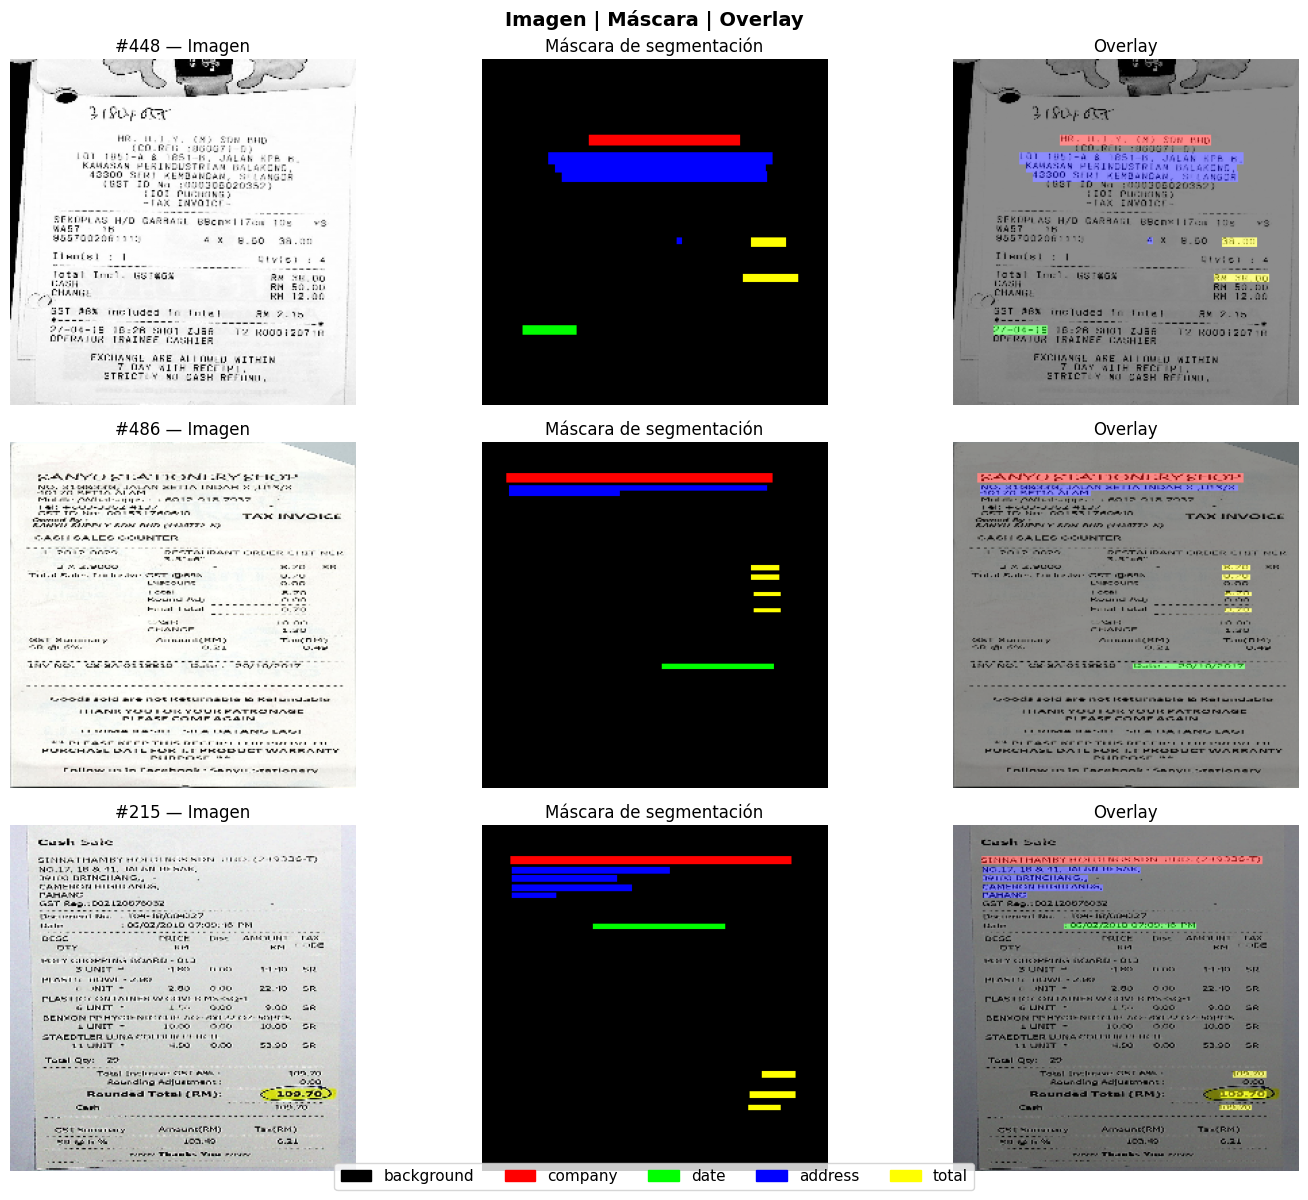

In [16]:
def build_segmentation_mask(img_orig, boxes_df, keys):
    """
    Genera una máscara de segmentación semántica del tamaño original de la imagen.
    Cada píxel inside un bbox de campo clave recibe el ID de clase correspondiente.
    """
    h, w = img_orig.shape[:2]
    mask = np.zeros((h, w), dtype=np.uint8)  # 0 = background

    matched = find_key_boxes(boxes_df, keys)
    for field, idxs in matched.items():
        class_id = FIELD_CLASSES[field]
        for i in idxs:
            row = boxes_df.loc[i]
            pts = np.array([[row.x1,row.y1],[row.x2,row.y2],
                            [row.x3,row.y3],[row.x4,row.y4]], np.int32)
            cv2.fillPoly(mask, [pts], class_id)
    return mask


def preprocess_sample(idx):
    """Carga, redimensiona y devuelve (img_norm, mask_resized)."""
    img, boxes_df, keys = load_sample(idx)
    mask = build_segmentation_mask(img, boxes_df, keys)

    img_resized  = cv2.resize(img,  (IMG_W, IMG_H), interpolation=cv2.INTER_LINEAR)
    mask_resized = cv2.resize(mask, (IMG_W, IMG_H), interpolation=cv2.INTER_NEAREST)

    img_norm = img_resized.astype(np.float32) / 255.0
    return img_norm, mask_resized


# ─── Verificación visual de las máscaras ─────────────────────────────────────
cmap = ListedColormap(["black","red","lime","blue","yellow"])

fig, axes = plt.subplots(3, 3, figsize=(15, 12))
for i, idx in enumerate(sample_ids[:3]):
    img_n, mask = preprocess_sample(idx)
    axes[i][0].imshow(img_n);                axes[i][0].set_title(f"#{idx} — Imagen")
    axes[i][1].imshow(mask, cmap=cmap, vmin=0, vmax=4)
    axes[i][1].set_title("Máscara de segmentación")
    axes[i][2].imshow(img_n)
    axes[i][2].imshow(mask, cmap=cmap, vmin=0, vmax=4, alpha=0.45)
    axes[i][2].set_title("Overlay")
    for ax in axes[i]: ax.axis("off")

from matplotlib.patches import Patch
handles = [Patch(color=c, label=n) for c, n in
           zip(["black","red","lime","blue","yellow"], CLASS_NAMES)]
fig.legend(handles=handles, loc="lower center", ncol=5, fontsize=11,
           bbox_to_anchor=(0.5, -0.01))
plt.suptitle("Imagen | Máscara | Overlay", fontsize=14, fontweight="bold")
plt.tight_layout()
plt.show()

Este código divide la lista total de índices (all_indices) en tres conjuntos para el entrenamiento del modelo:

Primera división: Separa el 70% para Entrenamiento (train_ids) y deja un 30% temporal (temp_ids).
Segunda división: Toma ese 30% temporal y lo divide a la mitad (0.50), resultando en un 15% para Validación (val_ids) y un 15% para Test (test_ids).

In [17]:
# ─── Dividir dataset en train / val / test (70 / 15 / 15) ───────────────────
train_ids, temp_ids = train_test_split(all_indices, test_size=0.30, random_state=SEED)
val_ids,   test_ids = train_test_split(temp_ids,    test_size=0.50, random_state=SEED)

print(f"Train : {len(train_ids)} muestras")
print(f"Val   : {len(val_ids)}   muestras")
print(f"Test  : {len(test_ids)}  muestras")

Train : 438 muestras
Val   : 94   muestras
Test  : 94  muestras


Este bloque configura el pipeline de datos eficiente de TensorFlow (tf.data).

- **load_tf_sample y tf_load:** Actúan como un puente. Como nuestra función de preprocesamiento (preprocess_sample) usa librerías externas como OpenCV y Pandas (que TensorFlow no entiende nativamente), usamos tf.py_function para envolverla e integrarla en el grafo de ejecución.

- **make_dataset**: Crea el flujo de datos final:
shuffle: Mezcla los datos (solo en entrenamiento) para evitar sesgos.
map: Carga y procesa las imágenes en paralelo (num_parallel_calls=AUTOTUNE).

- **batch:** Agrupa las muestras en lotes (de 8 en 8).
prefetch: Prepara el siguiente lote en la CPU mientras la GPU entrena con el actual, acelerando el proceso.

In [18]:
# ─── tf.data pipeline ────────────────────────────────────────────────────────
def load_tf_sample(idx_tensor):
    idx = idx_tensor.numpy().decode("utf-8")
    img, mask = preprocess_sample(idx)
    return img.astype(np.float32), mask.astype(np.int32)

def tf_load(idx):
    img, mask = tf.py_function(load_tf_sample, [idx], [tf.float32, tf.int32])
    img.set_shape([IMG_H, IMG_W, 3])
    mask.set_shape([IMG_H, IMG_W])
    return img, mask

def make_dataset(ids, shuffle=True):
    ds = tf.data.Dataset.from_tensor_slices(ids)
    if shuffle:
        ds = ds.shuffle(len(ids), seed=SEED)
    ds = ds.map(tf_load, num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
    return ds

ds_train = make_dataset(train_ids, shuffle=True)
ds_val   = make_dataset(val_ids,   shuffle=False)
ds_test  = make_dataset(test_ids,  shuffle=False)

print("Datasets creados:")
print(f"  ds_train → {ds_train}")
print(f"  ds_val   → {ds_val}")
print(f"  ds_test  → {ds_test}")

Datasets creados:
  ds_train → <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 256, 256), dtype=tf.int32, name=None))>
  ds_val   → <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 256, 256), dtype=tf.int32, name=None))>
  ds_test  → <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 256, 256), dtype=tf.int32, name=None))>


## 5. Arquitectura del Modelo — U-Net

Este código define la arquitectura de la red neuronal U-Net para la segmentación:

- **Entrada:** Recibe imágenes de 256x256 píxeles.
- **Encoder (Bajada):** Usa MobileNetV2 (una red eficiente preentrenada en ImageNet) para extraer características. Se congela (trainable=False) para no dañar sus pesos al inicio.
- **Skip Connections:** Guarda capas intermedias del encoder (s1, s2...) para pasarlas al decoder. Esto es vital para recuperar detalles finos (como texto) que se pierden al reducir la imagen.
- **Decoder (Subida):** Reconstruye la imagen paso a paso (upsample_block), duplicando el tamaño y concatenando la información guardada del encoder.
- **Salida:** La última capa genera 5 mapas de probabilidad (uno para cada clase: fondo, empresa, fecha, etc.).

In [19]:
def upsample_block(x, skip, filters, name):
    x = layers.UpSampling2D(2, name=f"{name}_up")(x)
    x = layers.Concatenate(name=f"{name}_concat")([x, skip])
    x = layers.Conv2D(filters, 3, padding="same", activation="relu", name=f"{name}_conv1")(x)
    x = layers.Conv2D(filters, 3, padding="same", activation="relu", name=f"{name}_conv2")(x)
    return x


def build_unet(input_shape=(IMG_H, IMG_W, 3), num_classes=NUM_CLASSES):
    """
    U-Net con encoder MobileNetV2 (pretrained ImageNet) y decoder personalizado.
    """
    inp = layers.Input(shape=input_shape, name="input_image")

    # ── Encoder: MobileNetV2 ─────────────────────────────────────────────────
    base = keras.applications.MobileNetV2(
        input_tensor=inp, include_top=False, weights="imagenet"
    )
    base.trainable = False  # Congelar encoder inicialmente

    # Skip connections en resoluciones intermedias
    s1 = base.get_layer("block_1_expand_relu").output   # 256×256
    s2 = base.get_layer("block_3_expand_relu").output   # 128×128
    s3 = base.get_layer("block_6_expand_relu").output   # 64×64
    s4 = base.get_layer("block_13_expand_relu").output  # 32×32
    bridge = base.get_layer("block_16_project").output  # 16×16

    # ── Decoder ───────────────────────────────────────────────────────────────
    d1 = upsample_block(bridge, s4, 512, "dec1")   # → 32×32
    d2 = upsample_block(d1,     s3, 256, "dec2")   # → 64×64
    d3 = upsample_block(d2,     s2, 128, "dec3")   # → 128×128
    d4 = upsample_block(d3,     s1,  64, "dec4")   # → 256×256

    # Última upsample para llegar a 512×512
    x  = layers.UpSampling2D(2, name="final_up")(d4)
    x  = layers.Conv2D(32, 3, padding="same", activation="relu", name="final_conv")(x)

    # Capa de salida — una probabilidad por clase por píxel
    out = layers.Conv2D(num_classes, 1, activation="softmax", name="output_mask")(x)

    model = Model(inputs=inp, outputs=out, name="UNet_MobileNetV2")
    return model


unet = build_unet()
unet.summary(line_length=90)

Model: "UNet_MobileNetV2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)             ┃ Output Shape         ┃      Param # ┃ Connected to          ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_image (InputLayer) │ (None, 256, 256, 3)  │            0 │ -                     │
├──────────────────────────┼──────────────────────┼──────────────┼───────────────────────┤
│ Conv1 (Conv2D)           │ (None, 128, 128, 32) │          864 │ input_image[0][0]     │
├──────────────────────────┼──────────────────────┼──────────────┼───────────────────────┤
│ bn_Conv1                 │ (None, 128, 128, 32) │          128 │ Conv1[0][0]           │
│ (BatchNormalization)     │                      │              │                       │
├──────────────────────────┼──────────────────────┼──────────────┼───────────────────────┤
│ Conv1_relu (ReLU)        │ (None, 128, 128, 32) │            0 │ bn_Conv1[0][0]        │
├──────────────────────────┼──────────────────────┼──────────────┼───────────────────────┤
│ expanded_conv_depthwise  │ (None, 128, 128, 32) │          288 │ Conv1_relu[0][0]      │
│ (DepthwiseConv2D)        │                      │              │                       │
├──────────────────────────┼──────────────────────┼──────────────┼───────────────────────┤
│ expanded_conv_depthwise… │ (None, 128, 128, 32) │          128 │ expanded_conv_depthw… │
│ (BatchNormalization)     │                      │              │                       │
├──────────────────────────┼──────────────────────┼──────────────┼───────────────────────┤
│ expanded_conv_depthwise… │ (None, 128, 128, 32) │            0 │ expanded_conv_depthw… │
│ (ReLU)                   │                      │              │                       │
├──────────────────────────┼──────────────────────┼──────────────┼───────────────────────┤
│ expanded_conv_project    │ (None, 128, 128, 16) │          512 │ expanded_conv_depthw… │
│ (Conv2D)                 │                      │              │                       │
├──────────────────────────┼──────────────────────┼──────────────┼───────────────────────┤
│ expanded_conv_project_BN │ (None, 128, 128, 16) │           64 │ expanded_conv_projec… │
│ (BatchNormalization)     │                      │              │                       │
├──────────────────────────┼──────────────────────┼──────────────┼───────────────────────┤
│ block_1_expand (Conv2D)  │ (None, 128, 128, 96) │        1,536 │ expanded_conv_projec… │
├──────────────────────────┼──────────────────────┼──────────────┼───────────────────────┤
│ block_1_expand_BN        │ (None, 128, 128, 96) │          384 │ block_1_expand[0][0]  │
│ (BatchNormalization)     │                      │              │                       │
├──────────────────────────┼──────────────────────┼──────────────┼───────────────────────┤
│ block_1_expand_relu      │ (None, 128, 128, 96) │            0 │ block_1_expand_BN[0]… │
│ (ReLU)                   │                      │              │                       │
├──────────────────────────┼──────────────────────┼──────────────┼───────────────────────┤
│ block_1_pad              │ (None, 129, 129, 96) │            0 │ block_1_expand_relu[… │
│ (ZeroPadding2D)          │                      │              │                       │
├──────────────────────────┼──────────────────────┼──────────────┼───────────────────────┤
│ block_1_depthwise        │ (None, 64, 64, 96)   │          864 │ block_1_pad[0][0]     │
│ (DepthwiseConv2D)        │                      │              │                       │
├──────────────────────────┼──────────────────────┼──────────────┼───────────────────────┤
│ block_1_depthwise_BN     │ (None, 64, 64, 96)   │          384 │ block_1_depthwise[0]… │
│ (BatchNormalization)     │                      │              │                       │
├──────────────────────────┼──────────────────────┼──────────────┼─────────────────────

 Total params: 11,336,581 (43.25 MB)

 Trainable params: 9,494,597 (36.22 MB)

 Non-trainable params: 1,841,984 (7.03 MB)

## 6. Entrenamiento del Modelo

Este bloque configura y ejecuta el entrenamiento del modelo con varias estrategias clave:

 - **Función de Pérdida Ponderada (weighted_sparse_cce):** Dado que la mayor parte de un recibo es "fondo" (clase 0), el modelo tiende a ignorar el texto pequeño. Esta función asigna un peso mayor (2.0) a los errores en los campos de texto (empresa, fecha, etc.) y un peso bajo (0.1) al fondo, forzando a la red a aprender las clases difíciles.

  - **Métrica IoU Personalizada:** Usamos la clase SparseMeanIoU que creamos para medir la precisión de la segmentación (Intersección sobre Unión), convirtiendo las probabilidades del modelo en clases antes de calcular.

- **Callbacks (Automatización):**

    *   **ModelCheckpoint:** Guarda solo la mejor versión del modelo basada en el IoU de validación.
    *   **EarlyStopping:** Detiene el entrenamiento si no mejora después de 7 épocas, evitando el sobreajuste.
    *   **ReduceLROnPlateau:** Reduce la velocidad de aprendizaje si el error deja de bajar, permitiendo un ajuste fino.










In [ ]:
# ─── Función de pérdida: Sparse Categorical Crossentropy + pesos por clase ───
# Las clases 1-4 son minoritarias vs background → se les da mayor peso
class_weights = np.array([0.1, 2.0, 2.0, 2.0, 2.0], dtype=np.float32)

def weighted_sparse_cce(y_true, y_pred):
    scce   = tf.keras.losses.sparse_categorical_crossentropy(y_true, y_pred)
    # Convertir etiquetas en pesos
    w_map  = tf.gather(class_weights, tf.cast(y_true, tf.int32))
    loss   = scce * w_map
    return tf.reduce_mean(loss)


# ─── Métrica: Mean IoU Adaptada ───────────────────────────────────────────────
class SparseMeanIoU(tf.keras.metrics.MeanIoU):
    def __init__(self, num_classes, name=None, dtype=None):
        super(SparseMeanIoU, self).__init__(num_classes=num_classes, name=name, dtype=dtype)

    def update_state(self, y_true, y_pred, sample_weight=None):
        # y_pred viene como probabilidades (B, H, W, C) -> convertir a clases (B, H, W)
        y_pred = tf.argmax(y_pred, axis=-1)
        return super().update_state(y_true, y_pred, sample_weight)

mean_iou = SparseMeanIoU(num_classes=NUM_CLASSES, name="mean_iou")


# ─── Compilar ─────────────────────────────────────────────────────────────────
unet.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss=weighted_sparse_cce,
    metrics=["accuracy", mean_iou]
)

# ─── Callbacks ────────────────────────────────────────────────────────────────
CKPT_PATH = os.path.join(BASE_DIR, "best_unet.keras")

callbacks = [
    ModelCheckpoint(CKPT_PATH, monitor="val_mean_iou", mode="max",
                    save_best_only=True, verbose=1),
    EarlyStopping(monitor="val_mean_iou", mode="max", patience=7,
                  restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3,
                      min_lr=1e-6, verbose=1)
]

print("Modelo compilado. Iniciando entrenamiento...")
history = unet.fit(
    ds_train,
    validation_data=ds_val,
    epochs=EPOCHS,
    callbacks=callbacks
)

Modelo compilado. Iniciando entrenamiento...
Epoch 1/15
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.6384 - loss: 0.4172 - mean_iou: 0.1498
Epoch 1: val_mean_iou improved from None to 0.19914, saving model to c:\Users\Gerardo\OneDrive - Oracle Corporation\Documents\ProyectoFinal\invoicesUNETAnalisis\best_unet.keras

Epoch 1: finished saving model to c:\Users\Gerardo\OneDrive - Oracle Corporation\Documents\ProyectoFinal\invoicesUNETAnalisis\best_unet.keras
28/28 ━━━━━━━━━━━━━━━━━━━━ 84s 3s/step - accuracy: 0.7577 - loss: 0.2830 - mean_iou: 0.1810 - val_accuracy: 0.7791 - val_loss: 0.1950 - val_mean_iou: 0.1991 - learning_rate: 0.0010
Epoch 2/15
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8432 - loss: 0.1715 - mean_iou: 0.2289
Epoch 2: val_mean_iou improved from 0.19914 to 0.34223, saving model to c:\Users\Gerardo\OneDrive - Oracle Corporation\Documents\ProyectoFinal\invoicesUNETAnalisis\best_unet.keras

Epoch 2: finished saving model to c:\Users\Gerardo\OneDrive - Oracle 

Este bloque realiza el Fine-Tuning (Ajuste Fino), una técnica avanzada para mejorar la precisión:

- **Descongelar Encoder:** trainable = True permite que la red MobileNetV2 (que antes estaba fija) ahora pueda aprender y modificar sus pesos internos.

- **Learning Rate Bajo (1e-5):** Usamos una velocidad de aprendizaje 100 veces menor que antes. Esto es crucial para hacer ajustes muy delicados en los pesos sin "romper" lo que la red ya aprendió de ImageNet.

- **Resultado:** Permite que el modelo se especialice totalmente en reconocer patrones de facturas (texto, líneas) en lugar de objetos genéricos.

In [ ]:
# ─── Fine-tuning: descongelar encoder y entrenar con LR bajo ─────────────────
print("=== Fine-tuning: descongelando encoder ===")

# Descongelar todas las capas del modelo (incluyendo el encoder MobileNetV2)
# Esto permite ajustar los pesos preentrenados
for layer in unet.layers:
    layer.trainable = True

# Usamos la clase personalizada SparseMeanIoU definida anteriormente
# para manejar la salida softmax del modelo
unet.compile(
    optimizer=keras.optimizers.Adam(1e-5),
    loss=weighted_sparse_cce,
    metrics=["accuracy", SparseMeanIoU(num_classes=NUM_CLASSES, name="mean_iou")]
)

history_ft = unet.fit(
    ds_train,
    validation_data=ds_val,
    epochs=15,
    callbacks=callbacks
)

=== Fine-tuning: descongelando encoder ===
Epoch 1/15
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8850 - loss: 0.1710 - mean_iou: 0.3338   
Epoch 1: val_mean_iou did not improve from 0.46804
28/28 ━━━━━━━━━━━━━━━━━━━━ 127s 3s/step - accuracy: 0.8844 - loss: 0.1702 - mean_iou: 0.3337 - val_accuracy: 0.7747 - val_loss: 0.1238 - val_mean_iou: 0.3294 - learning_rate: 1.0000e-05
Epoch 2/15
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 901ms/step - accuracy: 0.8475 - loss: 0.1142 - mean_iou: 0.3289
Epoch 2: val_mean_iou did not improve from 0.46804
28/28 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step - accuracy: 0.8477 - loss: 0.1139 - mean_iou: 0.3291 - val_accuracy: 0.8055 - val_loss: 0.1185 - val_mean_iou: 0.3417 - learning_rate: 1.0000e-05
Epoch 3/15
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 881ms/step - accuracy: 0.8719 - loss: 0.0946 - mean_iou: 0.3669
Epoch 3: val_mean_iou did not improve from 0.46804
28/28 ━━━━━━━━━━━━━━━━━━━━ 30s 1s/step - accuracy: 0.8719 - loss: 0.0946 - mean_iou: 0.3667 - val_accuracy: 0.8277 - v

Este código genera gráficos para evaluar el rendimiento del modelo:

- **Función plot_history:** Crea 3 gráficos visuales para monitorear el progreso:
Loss (Pérdida): Debe bajar constantemente.
Accuracy (Precisión): Debe subir.
- **Mean IoU:** La métrica más importante; indica qué tan bien se superponen las predicciones con la realidad.
Comparación: Dibuja una línea sólida para Entrenamiento y una punteada para Validación. Si la línea de validación empieza a empeorar mientras la de entrenamiento mejora, es señal de Overfitting.
- **Dos Fases:** Se ejecuta dos veces para ver cómo se comportó el modelo antes y después del Fine-Tuning.

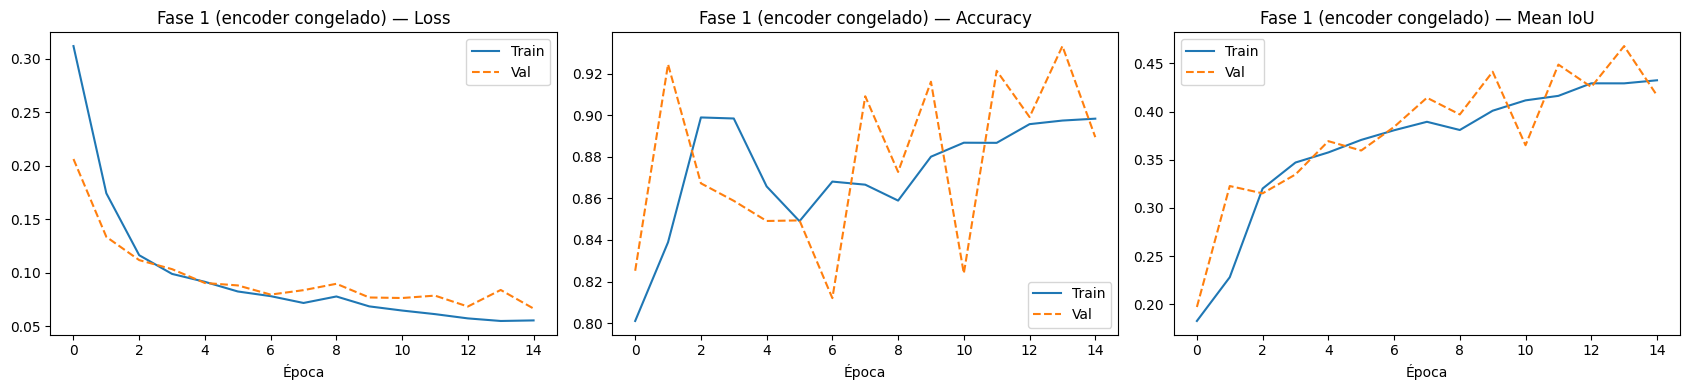

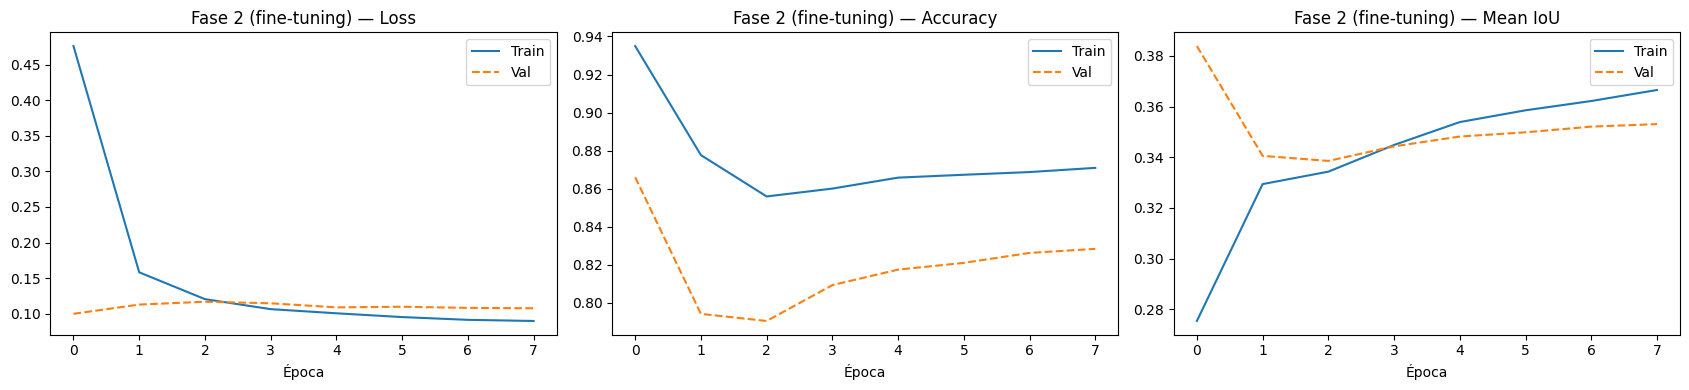

In [ ]:
# ─── Curvas de entrenamiento ─────────────────────────────────────────────────
def plot_history(hist, title=""):
    fig, axes = plt.subplots(1, 3, figsize=(17, 4))
    for ax, metric, label in zip(axes,
                                  ["loss",      "accuracy",   "mean_iou"],
                                  ["Loss",      "Accuracy",   "Mean IoU"]):
        ax.plot(hist.history[metric],     label="Train")
        ax.plot(hist.history[f"val_{metric}"], label="Val", linestyle="--")
        ax.set_title(f"{title} — {label}")
        ax.set_xlabel("Época"); ax.legend()
    plt.tight_layout(); plt.show()

plot_history(history,    "Fase 1 (encoder congelado)")
plot_history(history_ft, "Fase 2 (fine-tuning)")

## 7. Evaluación del Modelo

Este código evalúa el rendimiento final del modelo con datos que nunca ha visto (el conjunto de Test):

- **unet.evaluate:** Pasa todas las imágenes de prueba por el modelo y compara las predicciones con las máscaras reales.
Métricas reportadas:
- **Loss:** El error total (cuanto más bajo, mejor).
Pixel Accuracy: El porcentaje de píxeles clasificados correctamente. (Cuidado: puede ser engañoso si hay mucho fondo negro).
- **Mean IoU:** La métrica definitiva. Mide qué tan bien se solapan las áreas predichas con las reales. Un valor alto aquí confirma que el modelo realmente entiende dónde están los campos.

In [ ]:
# ─── Evaluar en test set ─────────────────────────────────────────────────────
print("Evaluando en test set...")
results = unet.evaluate(ds_test, verbose=1)
print(f"\n  Loss         : {results[0]:.4f}")
print(f"  Pixel Acc    : {results[1]:.4f}")
print(f"  Mean IoU     : {results[2]:.4f}")

Evaluando en test set...
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 644ms/step - accuracy: 0.8732 - loss: 0.0885 - mean_iou: 0.3885

  Loss         : 0.0947
  Pixel Acc    : 0.8734
  Mean IoU     : 0.3856


Este código genera una Matriz de Confusión Visual para entender los errores:

 - **Normalización:** Convierte los conteos brutos en porcentajes (divide cada fila por su total). Esto nos dice, por ejemplo, "El 90% de los píxeles de Fecha fueron correctos", en lugar de solo dar un número gigante.
- **Heatmap (Mapa de Calor):** Usa colores (azules) para mostrar dónde acierta más el modelo (diagonal principal) y dónde se confunde (fuera de la diagonal).
- **Anotaciones:** Escribe los valores exactos en cada celda para que puedas ver detalles finos, como "El modelo confunde la 'Dirección' con el 'Fondo' un 5% de las veces".

In [ ]:
# ─── IoU por clase + reporte de clasificación ────────────────────────────────
y_true_all, y_pred_all = [], []

for imgs, masks in ds_test:
    preds  = unet.predict(imgs, verbose=0)
    pred_classes = np.argmax(preds, axis=-1)      # (B, H, W)
    y_true_all.append(masks.numpy().flatten())
    y_pred_all.append(pred_classes.flatten())

y_true_flat = np.concatenate(y_true_all)
y_pred_flat = np.concatenate(y_pred_all)

# IoU por clase
iou_metric = tf.keras.metrics.MeanIoU(num_classes=NUM_CLASSES)
iou_metric.update_state(y_true_flat, y_pred_flat)
cm = iou_metric.total_cm.numpy()

iou_per_class = {}
for i in range(NUM_CLASSES):
    tp = cm[i, i]
    fn = cm[i, :].sum() - tp
    fp = cm[:, i].sum() - tp
    denom = tp + fp + fn
    iou_per_class[CLASS_NAMES[i]] = tp / denom if denom > 0 else 0.0

print("IoU por clase:")
for cls, iou in iou_per_class.items():
    print(f"  {cls:>12s} : {iou:.4f}")
print(f"\n  Mean IoU  : {np.mean(list(iou_per_class.values())):.4f}")

print("\nReporte de clasificación (nivel píxel):")
print(classification_report(y_true_flat, y_pred_flat,
                             target_names=CLASS_NAMES, zero_division=0))

IoU por clase:
    background : 0.8728
       company : 0.4425
          date : 0.1283
       address : 0.4163
         total : 0.0679

  Mean IoU  : 0.3856

Reporte de clasificación (nivel píxel):
              precision    recall  f1-score   support

  background       0.99      0.88      0.93   5848518
     company       0.52      0.75      0.61     77612
        date       0.16      0.39      0.23     46844
     address       0.44      0.90      0.59    154620
       total       0.07      0.93      0.13     32790

    accuracy                           0.87   6160384
   macro avg       0.44      0.77      0.50   6160384
weighted avg       0.96      0.87      0.91   6160384



Este código se encarga de visualizar la Matriz de Confusión de forma gráfica y legible:

- **Normalización:** Toma la matriz de conteos (cm) y divide cada fila por su suma total. Esto convierte los números en porcentajes, lo que nos permite responder preguntas como: "¿Qué porcentaje de las 'fechas' se detectaron correctamente?".
- **Mapa de Calor:** Usa imshow para pintar la matriz. Los colores más oscuras indican una mayor probabilidad, facilitando ver a golpe de vista dónde acierta el modelo (diagonal principal) y dónde falla.
- **Etiquetas:** Agrega los nombres de las clases (company, date, etc.) a los ejes y escribe el valor numérico dentro de cada celda.

⚠️ Variable 'cm' no encontrada. Calculándola ahora (esto puede tardar unos segundos)...
✅ Matriz de confusión calculada.


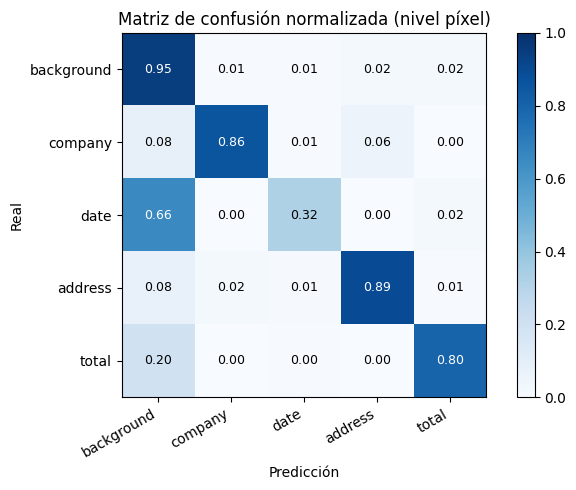

In [ ]:
# ─── Matriz de confusión (normalizada) ────────────────────────────────────────

# Lógica de seguridad: Calcular 'cm' si no existe (por si se saltó la celda anterior)
if 'cm' not in locals():
    if 'unet' in locals() and 'ds_test' in locals():
        print("⚠️ Variable 'cm' no encontrada. Calculándola ahora (esto puede tardar unos segundos)...")
        y_true_all, y_pred_all = [], []
        for imgs, masks in ds_test:
            preds  = unet.predict(imgs, verbose=0)
            pred_classes = np.argmax(preds, axis=-1)
            y_true_all.append(masks.numpy().flatten())
            y_pred_all.append(pred_classes.flatten())

        y_true_flat = np.concatenate(y_true_all)
        y_pred_flat = np.concatenate(y_pred_all)

        iou_metric = tf.keras.metrics.MeanIoU(num_classes=NUM_CLASSES)
        iou_metric.update_state(y_true_flat, y_pred_flat)
        cm = iou_metric.total_cm.numpy()
        print("✅ Matriz de confusión calculada.")
    else:
        print("❌ Error: No se puede calcular la matriz de confusión. Asegúrate de haber entrenado el modelo ('unet') y creado el dataset de test ('ds_test').")
        cm = None

if cm is not None:
    cm_norm = cm.astype(float)
    row_sums = cm_norm.sum(axis=1, keepdims=True)
    row_sums[row_sums == 0] = 1
    cm_norm /= row_sums

    fig, ax = plt.subplots(figsize=(7, 5))
    im = ax.imshow(cm_norm, cmap="Blues", vmin=0, vmax=1)
    ax.set_xticks(range(NUM_CLASSES)); ax.set_xticklabels(CLASS_NAMES, rotation=30, ha="right")
    ax.set_yticks(range(NUM_CLASSES)); ax.set_yticklabels(CLASS_NAMES)
    ax.set_xlabel("Predicción"); ax.set_ylabel("Real")
    ax.set_title("Matriz de confusión normalizada (nivel píxel)")
    plt.colorbar(im, ax=ax)
    for i in range(NUM_CLASSES):
        for j in range(NUM_CLASSES):
            ax.text(j, i, f"{cm_norm[i,j]:.2f}", ha="center", va="center",
                    color="white" if cm_norm[i,j] > 0.5 else "black", fontsize=9)
    plt.tight_layout()
    plt.show()

## 8. Inferencia en Imágenes Nuevas

Este bloque recupera el mejor modelo que se guardó durante el entrenamiento (gracias al ModelCheckpoint).

- **load_model:** Lee el archivo .keras del disco.
- **custom_objects:** Este parámetro es vital. Como usamos una función de pérdida personalizada (weighted_sparse_cce), Keras necesita que se la pasemos aquí para saber cómo reconstruir el modelo. Sin esto, la carga fallaría.

In [ ]:
# ─── Cargar el mejor modelo guardado ─────────────────────────────────────────

# 1. Redefinir objetos personalizados para asegurar compatibilidad al cargar
class_weights = np.array([0.1, 2.0, 2.0, 2.0, 2.0], dtype=np.float32)

def weighted_sparse_cce(y_true, y_pred):
    scce   = tf.keras.losses.sparse_categorical_crossentropy(y_true, y_pred)
    w_map  = tf.gather(class_weights, tf.cast(y_true, tf.int32))
    loss   = scce * w_map
    return tf.reduce_mean(loss)

class SparseMeanIoU(tf.keras.metrics.MeanIoU):
    # Añadimos **kwargs para aceptar argumentos extra del config guardado (ej: ignore_class)
    def __init__(self, num_classes, name=None, dtype=None, **kwargs):
        super(SparseMeanIoU, self).__init__(num_classes=num_classes, name=name, dtype=dtype, **kwargs)

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred = tf.argmax(y_pred, axis=-1)
        return super().update_state(y_true, y_pred, sample_weight)

# 2. Cargar modelo
best_model = keras.models.load_model(
    CKPT_PATH,
    custom_objects={
        "weighted_sparse_cce": weighted_sparse_cce,
        "SparseMeanIoU": SparseMeanIoU
    }
)
print(f"✅ Modelo cargado exitosamente desde: {CKPT_PATH}")

✅ Modelo cargado exitosamente desde: /content/best_unet.keras


Este código define la función predict_and_visualize, que es la herramienta final para ver al modelo en acción:

 - **Preprocesamiento:** Toma una imagen cruda, la redimensiona y normaliza (igual que en el entrenamiento).

 - **Predicción:** El modelo genera un mapa de probabilidad. np.argmax convierte ese mapa en una 'máscara' donde cada píxel tiene una etiqueta (ej: este píxel es 'Fecha').

 - **Visualización Inteligente (Post-procesamiento):**

    *   Separa cada clase (Empresa, Fecha, etc.).
    *   Usa cv2.findContours para detectar los bordes de las manchas de color y dibujar contornos limpios sobre la imagen.
    *   Calcula y escribe el nivel de confianza (probabilidad promedio) para saber qué tan seguro está el modelo.

- **Ejecución:** Finalmente, elige 4 recibos del set de prueba al azar y muestra el resultado: Imagen Original -> Lo que 've' el modelo (Máscara) -> Resultado Final.






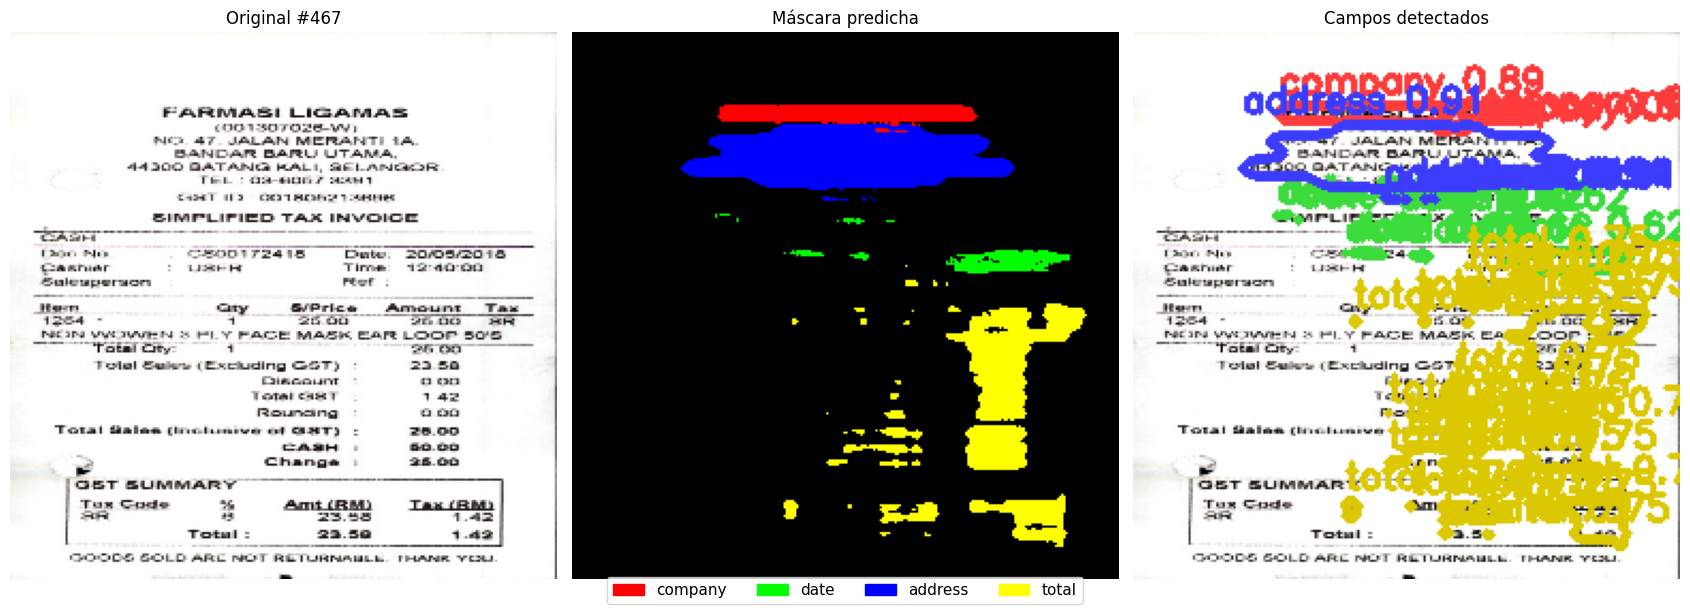

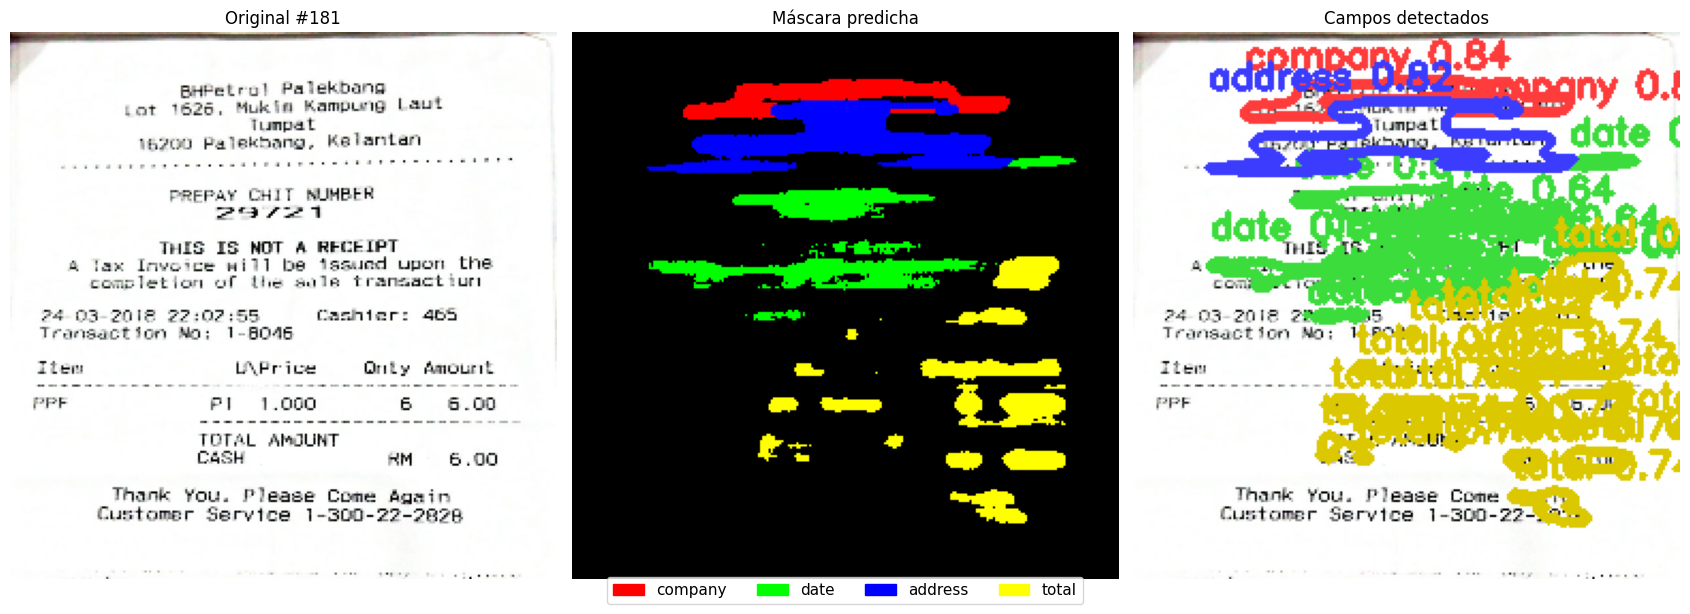

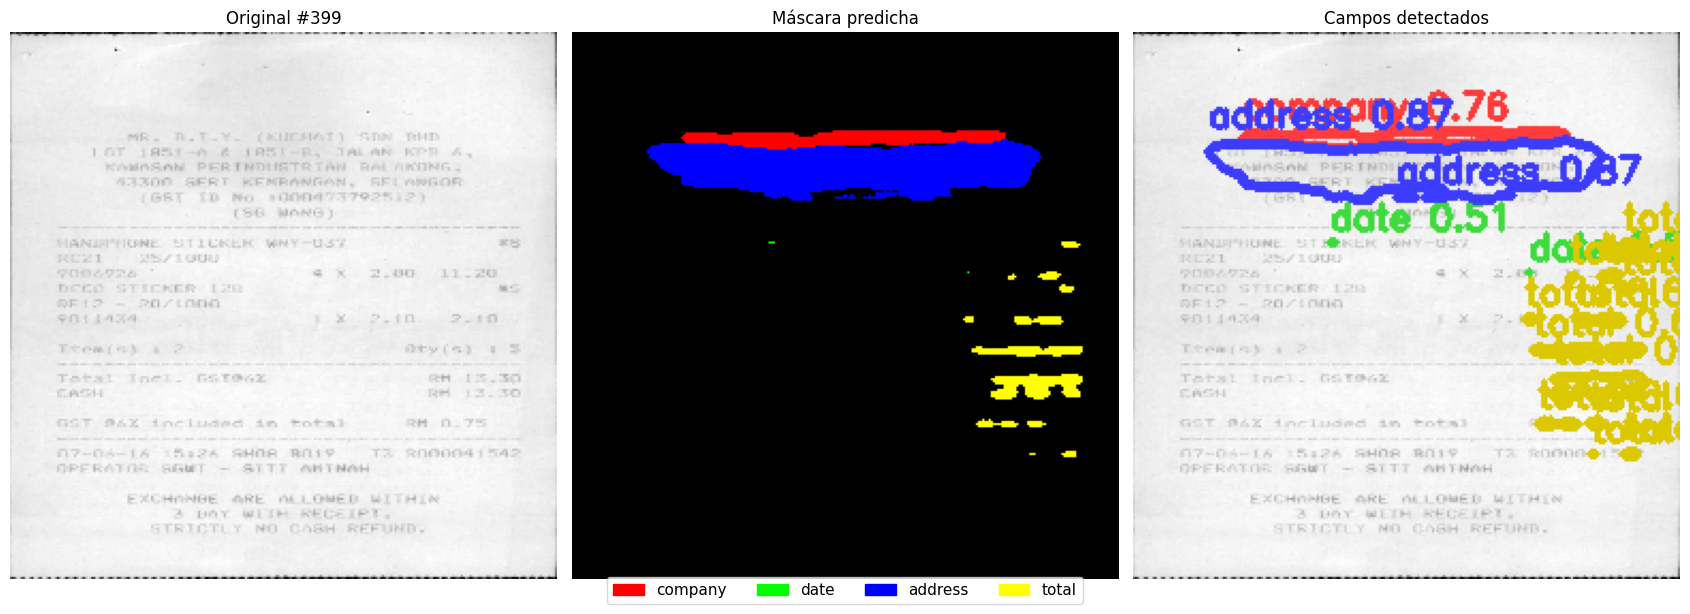

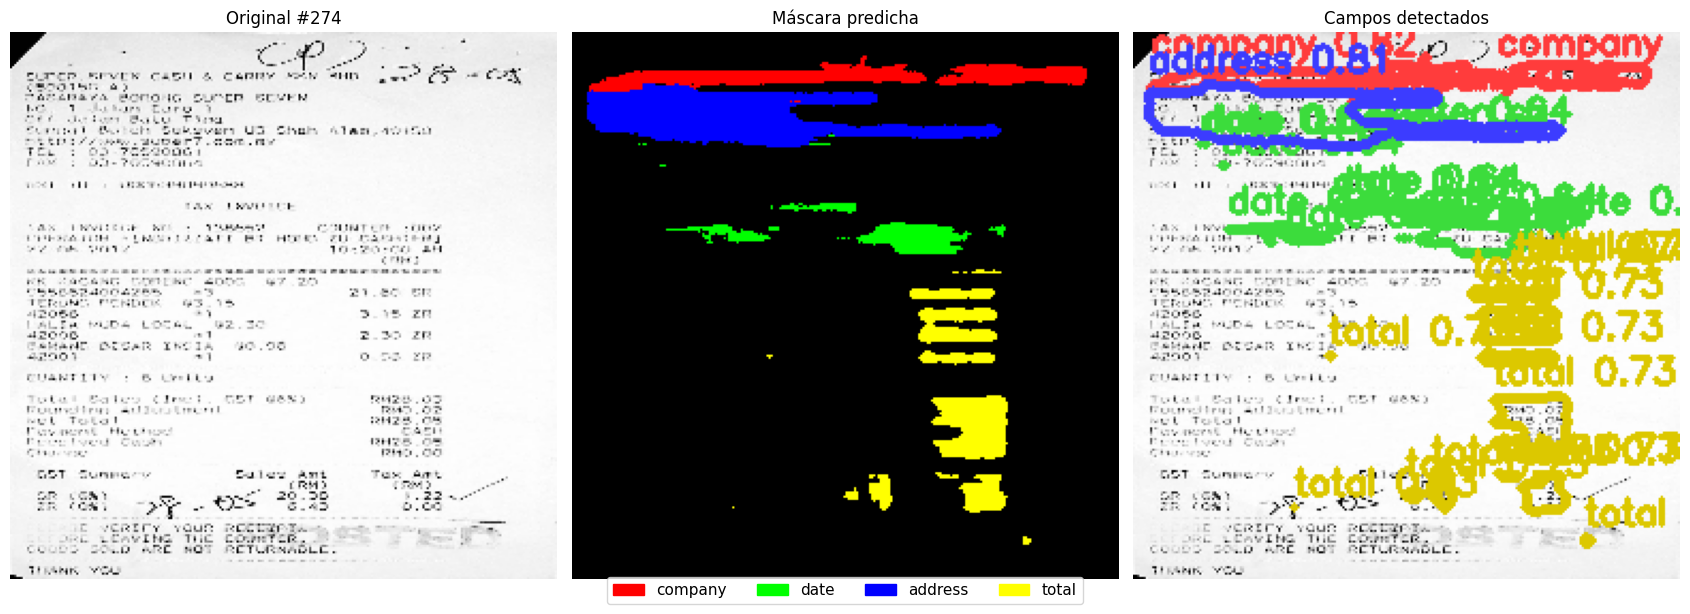

In [ ]:
def predict_and_visualize(idx, model, threshold=0.5):
    """
    Predice la máscara de segmentación para un idx y visualiza:
    - Imagen original
    - Máscara predicha
    - Overlay con contornos de campos detectados y confianza promedio
    """
    img, boxes_df, keys = load_sample(idx)
    img_resized = cv2.resize(img, (IMG_W, IMG_H))
    img_norm    = img_resized.astype(np.float32) / 255.0

    # Predicción
    inp   = np.expand_dims(img_norm, 0)   # (1, H, W, 3)
    probs = model.predict(inp, verbose=0)[0]   # (H, W, C)
    pred_mask = np.argmax(probs, axis=-1)       # (H, W)

    # Overlay con contornos por clase
    overlay = img_resized.copy()
    color_bgr = {1:(255,60,60), 2:(60,220,60), 3:(60,60,255), 4:(220,200,0)}

    for cls_id, color in color_bgr.items():
        cls_mask = (pred_mask == cls_id).astype(np.uint8) * 255
        if cls_mask.max() == 0:
            continue
        contours, _ = cv2.findContours(cls_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        cv2.drawContours(overlay, contours, -1, color, 3)
        # Confianza promedio en la región
        conf = probs[:,:,cls_id][pred_mask == cls_id].mean()
        for cnt in contours:
            x, y, w_c, h_c = cv2.boundingRect(cnt)
            label_text = f"{CLASS_NAMES[cls_id]} {conf:.2f}"
            cv2.putText(overlay, label_text, (x, max(y-6, 10)),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.55, color, 2)

    # Figura
    fig, axes = plt.subplots(1, 3, figsize=(17, 6))
    axes[0].imshow(img_resized);         axes[0].set_title(f"Original #{idx}")
    axes[1].imshow(pred_mask, cmap=cmap, vmin=0, vmax=4)
    axes[1].set_title("Máscara predicha")
    axes[2].imshow(overlay);             axes[2].set_title("Campos detectados")
    for ax in axes: ax.axis("off")

    from matplotlib.patches import Patch
    handles = [Patch(color=c, label=n) for c, n in
               zip(["red","lime","blue","yellow"], CLASS_NAMES[1:])]
    fig.legend(handles=handles, loc="lower center", ncol=4, fontsize=11,
               bbox_to_anchor=(0.5, -0.01))
    plt.tight_layout()
    plt.show()

    return pred_mask, probs


# ─── Correr inferencia en 4 muestras del test set ─────────────────────────────
np.random.seed(99)
infer_ids = np.random.choice(test_ids, 4, replace=False)

for idx in infer_ids:
    predict_and_visualize(idx, best_model)

Esta celda te permite probar el modelo con tus propias imágenes (fuera del dataset):

 - **Entrada Flexible:** A diferencia de las funciones anteriores, predict_external acepta una ruta de archivo (image_path), por lo que puedes subir una foto de un recibo nuevo a Colab y probarla aquí.

- **Pipeline Completo:** Realiza todo el proceso en uno: carga la imagen, la redimensiona a 256x256, la normaliza, hace la predicción y dibuja los contornos de los campos detectados.

- **Análisis Extra:** Imprime qué porcentaje de la imagen cubre cada campo (cobertura) y qué tan seguro está el modelo (conf_media).




--- Probando con imagen de ejemplo del dataset (000.jpg) ---


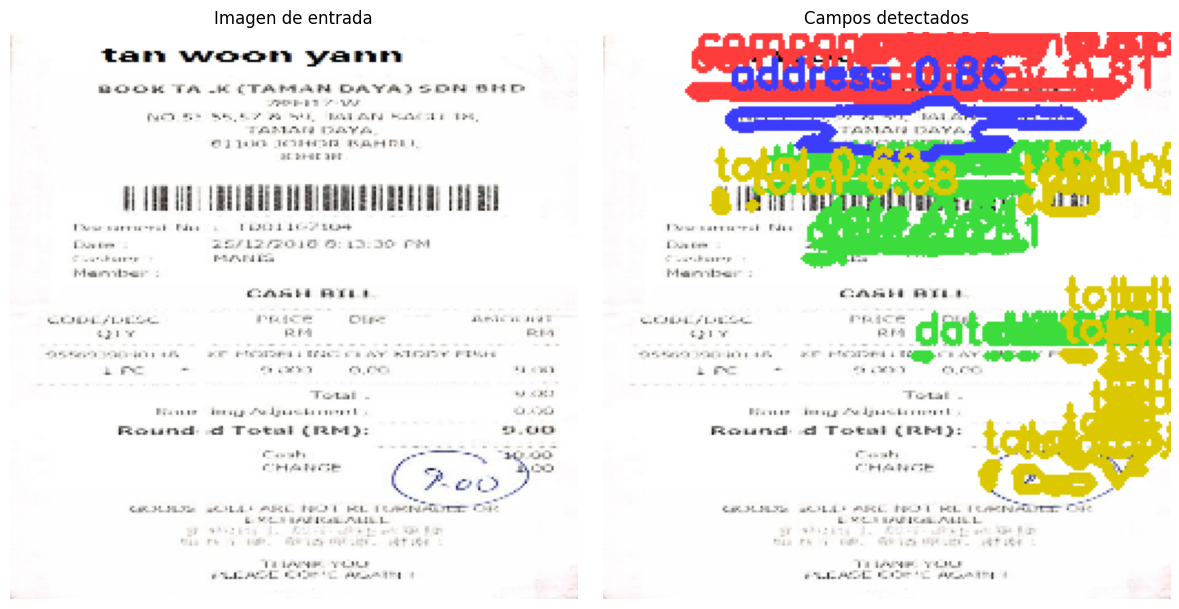

       company: cobertura=2.35%  conf_media=0.807
          date: cobertura=1.13%  conf_media=0.607
       address: cobertura=3.27%  conf_media=0.865
         total: cobertura=2.19%  conf_media=0.684
Celda lista.


In [ ]:
# ─── Inferencia en una imagen externa (fuera del dataset) ────────────────────
# Reemplaza la ruta por una imagen de recibo propia si deseas probar
def predict_external(image_path, model):
    if not os.path.exists(image_path):
        print(f"❌ Error: La imagen '{image_path}' no existe. Verifica la ruta.")
        return

    img = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)
    img_resized = cv2.resize(img, (IMG_W, IMG_H))
    img_norm    = img_resized.astype(np.float32) / 255.0
    inp  = np.expand_dims(img_norm, 0)
    probs     = model.predict(inp, verbose=0)[0]
    pred_mask = np.argmax(probs, axis=-1)

    overlay = img_resized.copy()
    color_bgr = {1:(255,60,60), 2:(60,220,60), 3:(60,60,255), 4:(220,200,0)}
    for cls_id, color in color_bgr.items():
        cls_mask = (pred_mask == cls_id).astype(np.uint8) * 255
        if cls_mask.max() == 0:
            continue
        contours, _ = cv2.findContours(cls_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        cv2.drawContours(overlay, contours, -1, color, 3)
        conf = probs[:,:,cls_id][pred_mask == cls_id].mean()
        for cnt in contours:
            x, y, w_c, h_c = cv2.boundingRect(cnt)
            cv2.putText(overlay, f"{CLASS_NAMES[cls_id]} {conf:.2f}", (x, max(y-6,10)),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2)

    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    axes[0].imshow(img_resized); axes[0].set_title("Imagen de entrada")
    axes[1].imshow(overlay);     axes[1].set_title("Campos detectados")
    for ax in axes: ax.axis("off")
    plt.tight_layout(); plt.show()

    # Extraer texto del campo total como ejemplo
    for cls_id in range(1, NUM_CLASSES):
        region = pred_mask == cls_id
        coverage = region.sum() / region.size
        print(f"  {CLASS_NAMES[cls_id]:>12s}: cobertura={coverage*100:.2f}%  "
              f"conf_media={probs[:,:,cls_id][region].mean() if region.any() else 0:.3f}")


# ─── Lógica de Carga Automática del Modelo ───────────────────────────────────
if 'best_model' not in locals():
    ckpt_path = "best_unet.keras"
    if os.path.exists(ckpt_path):
        print(f"🔄 Variable 'best_model' no encontrada. Cargando desde {ckpt_path}...")
        try:
            # compile=False permite cargar sin necesitar la loss function personalizada
            best_model = keras.models.load_model(ckpt_path, compile=False)
            print("✅ Modelo cargado exitosamente.")
        except Exception as e:
            print(f"❌ Error cargando el modelo: {e}")
    else:
        print("⚠️ Error: No se encuentra 'best_model' ni el archivo 'best_unet.keras'.")
        print("   Debes entrenar el modelo (Sección 6) antes de probarlo.")

# Ejecutar inferencia si el modelo existe
if 'best_model' in locals():
    # Ejemplo 1: Probando con una imagen del dataset que SÍ existe
    print("\n--- Probando con imagen de ejemplo del dataset (000.jpg) ---")
    predict_external("data/img/000.jpg", best_model)

    # Ejemplo 2: Para usar TU imagen (descomenta las líneas de abajo)
    # print("\n--- Probando con imagen propia ---")
    # predict_external("/content/mi_recibo.jpg", best_model)
else:
    print("No se puede ejecutar la inferencia sin un modelo entrenado.")

print("Celda lista.")

## 9. Aplicación Interactiva — Analizador de Facturas

Sube cualquier imagen de factura o recibo y el modelo U-Net detectará automáticamente los campos clave:

| Color | Campo |
|-------|-------|
| 🔴 Rojo | **Empresa** (Company) |
| 🟢 Verde | **Fecha** (Date) |
| 🔵 Azul | **Dirección** (Address) |
| 🟡 Amarillo | **Total** (Total) |

> **Nota:** Si tienes `pytesseract` instalado, la app también intentará extraer el texto de cada región detectada mediante OCR.

In [ ]:
import io
import ipywidgets as widgets
from IPython.display import display, clear_output
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch
import __main__

# ─── Intentar importar pytesseract (OCR opcional) ───────────────────────────
try:
    import pytesseract
    OCR_AVAILABLE = True
    print("✅ pytesseract detectado — se extraerá texto de las regiones detectadas.")
except ImportError:
    OCR_AVAILABLE = False
    print("ℹ️  pytesseract no encontrado. Se mostrará confianza y cobertura, pero no texto.")
    print("   Para activar OCR: pip install pytesseract  (+ instalar Tesseract binario)")

# ─── Constantes del modelo ───────────────────────────────────────────────────
_CLASS_NAMES  = getattr(__main__, 'CLASS_NAMES',  ["background", "company", "date", "address", "total"])
_NUM_CLASSES  = getattr(__main__, 'NUM_CLASSES',  5)
_IMG_H        = getattr(__main__, 'IMG_H',        256)
_IMG_W        = getattr(__main__, 'IMG_W',        256)
_cmap         = getattr(__main__, 'cmap',
                        ListedColormap(["black", "red", "lime", "blue", "yellow"]))

_FIELD_COLORS_BGR = {1: (255,  60,  60),
                     2: ( 60, 220,  60),
                     3: ( 60,  60, 255),
                     4: (220, 200,   0)}
_FIELD_COLORS_HEX = {1: "#FF3C3C", 2: "#3CDC3C", 3: "#3C3CFF", 4: "#DCC800"}
_FIELD_LABELS     = {1: "Empresa (Company)",
                     2: "Fecha (Date)",
                     3: "Dirección (Address)",
                     4: "Total"}

# ─── Lógica de inferencia ────────────────────────────────────────────────────
def _get_model():
    """Recupera best_model desde el namespace global del notebook."""
    model = getattr(__main__, 'best_model', None)
    if model is None:
        model = getattr(__main__, 'unet', None)
    return model


def _analyze_invoice(image_bytes, model):
    """
    Ejecuta inferencia sobre los bytes de imagen y devuelve:
      overlay (np.ndarray RGB), pred_mask (np.ndarray), field_results (dict)
    """
    nparr      = np.frombuffer(image_bytes, np.uint8)
    img        = cv2.imdecode(nparr, cv2.IMREAD_COLOR)
    img        = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    orig_h, orig_w = img.shape[:2]

    img_resized = cv2.resize(img, (_IMG_W, _IMG_H))
    img_norm    = img_resized.astype(np.float32) / 255.0
    inp         = np.expand_dims(img_norm, 0)

    probs       = model.predict(inp, verbose=0)[0]          # (H, W, C)
    pred_mask   = np.argmax(probs, axis=-1)                 # (H, W)

    overlay     = img_resized.copy()
    field_results = {}

    for cls_id, color_bgr in _FIELD_COLORS_BGR.items():
        cls_mask = (pred_mask == cls_id).astype(np.uint8) * 255
        if cls_mask.max() == 0:
            continue

        contours, _ = cv2.findContours(cls_mask, cv2.RETR_EXTERNAL,
                                       cv2.CHAIN_APPROX_SIMPLE)
        cv2.drawContours(overlay, contours, -1, color_bgr, 3)

        conf     = float(probs[:, :, cls_id][pred_mask == cls_id].mean())
        coverage = float((pred_mask == cls_id).sum() / pred_mask.size)

        # Intentar OCR (opcional)
        ocr_text = ""
        if OCR_AVAILABLE:
            mask_orig = cv2.resize(cls_mask, (orig_w, orig_h))
            img_full  = cv2.resize(img, (orig_w, orig_h))
            coords    = cv2.findNonZero(mask_orig)
            if coords is not None:
                rx, ry, rw, rh = cv2.boundingRect(coords)
                cropped = img_full[ry:ry + rh, rx:rx + rw]
                try:
                    ocr_text = pytesseract.image_to_string(
                        cropped, config="--psm 6").strip()
                except Exception:
                    ocr_text = "(error OCR)"

        for cnt in contours:
            x, y, wc, hc = cv2.boundingRect(cnt)
            label = f"{_CLASS_NAMES[cls_id]} {conf:.2f}"
            cv2.putText(overlay, label, (x, max(y - 6, 10)),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.55, color_bgr, 2)

        field_results[cls_id] = {
            "label":      _FIELD_LABELS[cls_id],
            "coverage":   coverage * 100,
            "confidence": conf,
            "text":       ocr_text,
        }

    return overlay, pred_mask, field_results, probs


# ─── Construcción de la UI ───────────────────────────────────────────────────
_title = widgets.HTML(value="""
<div style="background:linear-gradient(135deg,#1a1a2e,#16213e);
            padding:18px 24px;border-radius:14px;margin-bottom:12px;
            border:1px solid #0f3460;">
  <h2 style="color:#e94560;margin:0;text-align:center;font-family:Arial,sans-serif;">
    🔍 Analizador de Facturas — Invoice Field Detector
  </h2>
  <p style="color:#a8b2d8;text-align:center;margin:8px 0 0;font-size:13px;">
    Modelo U-Net · Campos: Empresa · Fecha · Dirección · Total
  </p>
</div>
""")

_upload = widgets.FileUpload(
    accept=".jpg,.jpeg,.png,.bmp,.tiff",
    multiple=False,
    description="📂 Subir imagen",
    style={"description_width": "initial"},
    layout=widgets.Layout(width="220px"),
)

_btn_analyze = widgets.Button(
    description="🔍 Analizar",
    button_style="primary",
    layout=widgets.Layout(width="160px", height="36px"),
    style={"font_weight": "bold"},
)

_btn_clear = widgets.Button(
    description="🗑️ Limpiar",
    button_style="warning",
    layout=widgets.Layout(width="110px", height="36px"),
)

_status = widgets.HTML(
    value='<p style="color:#888;font-style:italic;margin:4px 0;">Esperando imagen…</p>'
)

_out_plot   = widgets.Output()
_out_table  = widgets.HTML(value="")


def _on_analyze(_btn):
    model = _get_model()
    if model is None:
        _status.value = ('<p style="color:red;">❌ Modelo no encontrado. '
                         'Ejecuta primero la celda de carga del modelo (Sección 8).</p>')
        return

    if not _upload.value:
        _status.value = '<p style="color:orange;">⚠️ Selecciona una imagen primero.</p>'
        return

    _status.value = '<p style="color:#4CAF50;">⏳ Analizando… por favor espera.</p>'

    # Compatibilidad ipywidgets v7 y v8
    uploaded_item = _upload.value
    if isinstance(uploaded_item, dict):
        image_bytes = list(uploaded_item.values())[0]["content"]
    else:
        image_bytes = uploaded_item[0]["content"]

    if isinstance(image_bytes, memoryview):
        image_bytes = bytes(image_bytes)

    try:
        overlay, pred_mask, field_results, probs = _analyze_invoice(image_bytes, model)
    except Exception as exc:
        _status.value = f'<p style="color:red;">❌ Error: {exc}</p>'
        import traceback
        with _out_plot:
            clear_output(wait=True)
            traceback.print_exc()
        return

    # ── Visualización ────────────────────────────────────────────────────────
    with _out_plot:
        clear_output(wait=True)

        nparr   = np.frombuffer(image_bytes, np.uint8)
        img_raw = cv2.imdecode(nparr, cv2.IMREAD_COLOR)
        img_raw = cv2.cvtColor(img_raw, cv2.COLOR_BGR2RGB)
        img_disp = cv2.resize(img_raw, (_IMG_W, _IMG_H))

        fig, axes = plt.subplots(1, 3, figsize=(18, 6),
                                 facecolor="#12121f")
        for ax in axes:
            ax.set_facecolor("#12121f")

        axes[0].imshow(img_disp)
        axes[0].set_title("📄 Imagen Original", color="white", fontsize=13,
                           fontweight="bold")

        axes[1].imshow(pred_mask, cmap=_cmap, vmin=0, vmax=4)
        axes[1].set_title("🗺️ Máscara U-Net", color="white", fontsize=13,
                           fontweight="bold")

        axes[2].imshow(overlay)
        axes[2].set_title("✅ Campos Detectados", color="white", fontsize=13,
                           fontweight="bold")

        for ax in axes:
            ax.axis("off")

        _legend = [
            Patch(color="#FF3C3C", label="Empresa"),
            Patch(color="#3CDC3C", label="Fecha"),
            Patch(color="#3C3CFF", label="Dirección"),
            Patch(color="#DCC800", label="Total"),
        ]
        fig.legend(handles=_legend, loc="lower center", ncol=4, fontsize=12,
                   facecolor="#1e1e2e", labelcolor="white",
                   bbox_to_anchor=(0.5, -0.03))
        plt.tight_layout()
        plt.show()

    # ── Tabla de resultados ──────────────────────────────────────────────────
    if field_results:
        rows_html = ""
        for cls_id in sorted(field_results):
            info  = field_results[cls_id]
            color = _FIELD_COLORS_HEX[cls_id]
            bar_w = int(info["confidence"] * 100)
            bar   = (f'<div style="background:#333;border-radius:4px;height:10px;width:120px;">'
                     f'<div style="background:{color};width:{bar_w}%;height:10px;'
                     f'border-radius:4px;"></div></div>')

            if OCR_AVAILABLE:
                txt_cell = (f"<td style='padding:8px;color:#eee;font-family:monospace;"
                            f"font-size:12px;max-width:300px;word-break:break-word;'>"
                            f"{info['text'] or '<i style=\"color:#666\">sin texto</i>'}</td>")
            else:
                txt_cell = ("<td style='padding:8px;color:#555;font-size:12px;'>"
                            "<i>instala pytesseract</i></td>")

            rows_html += f"""
            <tr style="border-bottom:1px solid #2a2a3a;">
              <td style="padding:10px;">
                <span style="background:{color};color:#111;padding:3px 10px;
                             border-radius:5px;font-weight:bold;font-size:12px;">
                  {info['label']}
                </span>
              </td>
              <td style="padding:10px;color:#eee;text-align:center;">
                {bar}<br>
                <span style="font-size:11px;color:#aaa;">{info['confidence']:.1%}</span>
              </td>
              <td style="padding:10px;color:#2196F3;text-align:center;">
                {info['coverage']:.2f}%
              </td>
              {txt_cell}
            </tr>"""

        ocr_th = ("<th style='color:#aaa;padding:8px;text-align:left;'>Texto (OCR)</th>"
                  if OCR_AVAILABLE else
                  "<th style='color:#444;padding:8px;'>Texto (OCR)</th>")
        ocr_tip = ("" if OCR_AVAILABLE else
                   "<p style='color:#666;font-size:11px;margin-top:6px;'>"
                   "💡 <code>pip install pytesseract</code> + Tesseract binario</p>")

        _out_table.value = f"""
        <div style="background:#1e1e2e;padding:16px;border-radius:12px;
                    margin-top:10px;border:1px solid #2a2a3a;">
          <h3 style="color:#e94560;margin-top:0;">📊 Resultados del Análisis</h3>
          <table style="width:100%;border-collapse:collapse;font-family:Arial,sans-serif;">
            <thead>
              <tr style="border-bottom:2px solid #3a3a5a;">
                <th style="color:#aaa;padding:8px;text-align:left;">Campo detectado</th>
                <th style="color:#aaa;padding:8px;">Confianza</th>
                <th style="color:#aaa;padding:8px;">Cobertura (px)</th>
                {ocr_th}
              </tr>
            </thead>
            <tbody>{rows_html}</tbody>
          </table>
          {ocr_tip}
        </div>"""
    else:
        _out_table.value = """
        <div style="background:#2d1b1b;padding:14px;border-radius:10px;color:#ff6b6b;margin-top:10px;">
          ⚠️ No se detectaron campos clave. Intenta con otra imagen de factura o recibo.
        </div>"""

    n = len(field_results)
    _status.value = (f'<p style="color:#4CAF50;font-weight:bold;">'
                     f'✅ Análisis completado — {n} campo{"s" if n != 1 else ""} detectado{"s" if n != 1 else ""}.</p>')


def _on_clear(_btn):
    _upload.value = {} if isinstance(_upload.value, dict) else ()
    _out_table.value = ""
    _status.value = '<p style="color:#888;font-style:italic;margin:4px 0;">Esperando imagen…</p>'
    with _out_plot:
        clear_output()


_btn_analyze.on_click(_on_analyze)
_btn_clear.on_click(_on_clear)

_controls = widgets.HBox(
    [_upload, _btn_analyze, _btn_clear],
    layout=widgets.Layout(gap="12px", align_items="center", margin="8px 0"),
)

_app = widgets.VBox(
    [_title, _controls, _status, _out_plot, _out_table],
    layout=widgets.Layout(padding="8px"),
)

display(_app)